> Initial pre-processing include the extraction of information about target CpGs. The code is available in `script_helpers`. Master-script: `script_helpers/run_all.sh`

## Load packages

In [165]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib.patches import Rectangle
from scipy.stats import truncnorm, norm

from sklearn.metrics import mean_absolute_error

## Define default parameters

In [2]:
plt.rcParams["figure.figsize"] = (4, 4)

DATA_FOLDER = 'data'
RANDOMSTATE = 42

In [3]:
colors = ['#bebada', '#fb8072', '#80b1d', 'black', '#d9d9d9']

## Modelling single-cell one site DNAm state

Matrix of initial states: $\mathbb{\Pi} = (p_{0}\quad p_{1})$

In [4]:
Pi_init = np.array([[1, 0]])
Pi_init

array([[1, 0]])

Matrix of initial transition probabilities: $\mathbb{P} = \begin{pmatrix} 1-p & p \\ q &1-q \end{pmatrix} $

In [5]:
p, q = 0.5 * 10 ** (-4), 0.5 * 10 ** (-4)

P_init = np.array([[1 - p, p], [q, 1 - q]])
P_init

array([[9.9995e-01, 5.0000e-05],
       [5.0000e-05, 9.9995e-01]])

Forward equation for Markov chain process (for inconditional probabilities):
$$ \mathbb{\Pi}^{(t)} = \mathbb{\Pi} \cdot \mathbb{P}^{(k)} = \mathbb{\Pi} \cdot \mathbb{P}^k $$

In [6]:
def roll_through_Pi_t(dnam_frac: float, 
                     p: float, 
                     q: float, 
                     num_states: int) -> list:
    
    P_init = np.array([[1 - p, p], [q, 1 - q]])
    Pi_init = np.array([[1 - dnam_frac, dnam_frac]])
    
    P_dnam = []
    P_t = None
    
    for _ in range(0, num_states):
        if P_t is None:
            P_t = P_init
        else:
            P_t = P_t @ P_init
        Pi_t = (Pi_init @ P_t)
        P_dnam.append(Pi_t[:, 1])
        
    return P_dnam

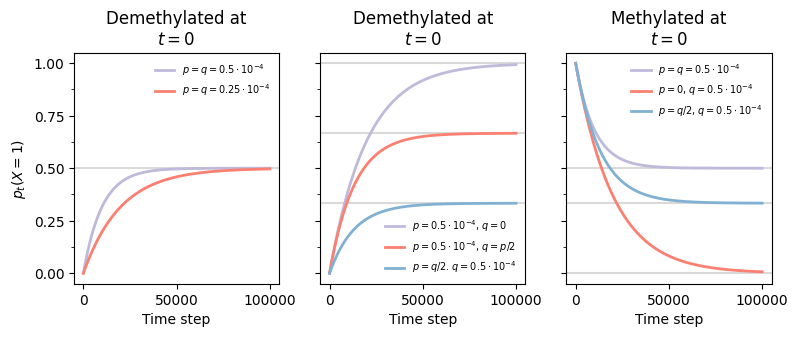

In [7]:
num_states = 100000

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 3))

dnam_frac = 0
p = 0.5 * 10 ** (-4)
q = 0.5 * 10 ** (-4)

# steady state
axs[0].axhline(p/(q+p), c='#d9d9d9')
# plot sim
axs[0].plot(range(num_states), roll_through_Pi_t(dnam_frac, p, q, num_states), 
                         linewidth=2, c='#bebada', label='$p=q=0.5\cdot10^{-4}$')
axs[0].plot(range(num_states), roll_through_Pi_t(dnam_frac, p/2, q/2, num_states), 
                         linewidth=2, c='#fb8072', label='$p=q=0.25\cdot10^{-4}$')

axs[0].set_ylabel('$p_t(X=1)$')
axs[0].set_title('Demethylated at\n$t=0$')
axs[0].legend(frameon=False, fontsize="7", loc='upper right')

# steady states
axs[1].axhline(p/(0*q+p), c='#d9d9d9')
axs[1].axhline(p/(2*(q+p/2)), c='#d9d9d9')
axs[1].axhline(p/(q/2+p), c='#d9d9d9')
# plot sim
axs[1].plot(range(num_states), roll_through_Pi_t(dnam_frac, p, 0, num_states), 
                         linewidth=2, c='#bebada', label='$p=0.5\cdot10^{-4}$, $q=0$')
axs[1].plot(range(num_states), roll_through_Pi_t(dnam_frac, p, p/2, num_states), 
                         linewidth=2, c='#fb8072', label='$p=0.5\cdot10^{-4}$, $q=p/2$')
axs[1].plot(range(num_states), roll_through_Pi_t(dnam_frac, q/2, q, num_states), 
                         linewidth=2, c='#80b1d3', label='$p=q/2$. $q=0.5\cdot10^{-4}$')
axs[1].set_title('Demethylated at\n$t=0$')
axs[1].legend(frameon=False, fontsize="7", loc='lower right')

dnam_frac = 1
# steady states
axs[2].axhline(p/(q+p), c='#d9d9d9')
axs[2].axhline(0 * p/(q+p*0), c='#d9d9d9')
axs[2].axhline(p/(2*(q+p/2)), c='#d9d9d9')
# plot sim
axs[2].plot(range(num_states), roll_through_Pi_t(dnam_frac, p, q, num_states), 
                         linewidth=2, c='#bebada', label='$p=q=0.5\cdot10^{-4}$')
axs[2].plot(range(num_states), roll_through_Pi_t(dnam_frac, 0, q, num_states), 
                         linewidth=2, c='#fb8072', label='$p=0$, $q=0.5\cdot10^{-4}$')
axs[2].plot(range(num_states), roll_through_Pi_t(dnam_frac, q/2, q, num_states), 
                         linewidth=2, c='#80b1d3', label='$p=q/2$, $q=0.5\cdot10^{-4}$')
axs[2].set_title('Methylated at\n$t=0$')
axs[2].legend(frameon=False, fontsize="7", loc='upper right')

for ax in axs:
    ax.set_xlabel('Time step')
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.set_yticks(np.arange(0, 1.01, 0.125), minor=True)

plt.show()

## Constructing stochastic model

### Procedure description

When we switch from the one-cell to cell population, we need to generalize our model. 
To do so, we provide several definitions.

First, instead of one CpG site, we will consider several (353) that belong to Horvath's clock. For each of CpG $c$, we need to define independent procedure of estimaion of methylation change.  
Second, instead of one boolinan variable, $X \in \{1, 0\}$ defining methylation status in single cell, we will operate with the fraction of methylated sites in particular position, named DNAm.

Thus, taking into account the described diffences, a simulation of the stochastic  will consists of the following steps.

#### 1. Initial methylation status distribution.  
The initial methylation status corresponds to fraction of methylated sites in particular position at the beginning of observation (DNAm). Following the paper, we will define the initial methylation status for each CpG $c$ as an average DNAm for young samples (avgDNAm(Young)). 

#### 2. Definition of probability of transition  
We will model the change of methylation status at CpG $c$ occuring with probability $p_c$:

$$p_c = 1 - e^{-\gamma |\text{EffSize}_c|} $$
where $\gamma$ is global probability of a DNAm change (discussed below), and $\text{EffSize}_{c}$ is an effect size, which defined as difference in methylation fraction DNAm for betweem old and young. Mathematically, for each CpG $c$ in a CpG set:
$$ \text{EffSize}_c = \text{avgDNAm(Old)} - \text{avgDNAm(Young)}$$

#### 3. Definition of transition
3.1. Since we switched to cell population, we need to define how the transition will happen. Since we have a population, the change in methylation status of CpG $c$ will change of DNAm from $\beta _c ^{(t)}$ at time step $t$ to $\beta _c ^{(t+1)}$. The DNAm values are defined as $\beta_c$ since they are beta-distributed (shown below).  
3.2. The size of DNAm change is defined as a random deviation $r_{c}$ from truncated normal distribution $r_{c} \sim \mathcal{N}_{+}(0, \sigma)$. Sign of change is same as siogn of effect size: $\text{sign}(\text{EffSize}_{c})$.  
3.3. Change in DNAm. Since the DNAms $\beta _c ^{(t)}$ are beta-distributed and the $r$ belongs to truncated normal distribution we first transform the DNAm to normal distribution, change the value, and then convert it back to the beta-values. Thus,
$$\beta _c ^{(t)} \quad \rightarrow \quad x_c^{(t)} = iF(\beta_{c}^{(t)}),$$ 
where $iF$ is inverse of the normal cumulative distribution function. Next,
$$ x_c^{(t+1)} = x_c^{(t)} + \text{sign}( \text{EffSize}_{c} ) \cdot r_{c}, \  r_{c} \sim \mathcal{N}_{+}(0, \sigma)$$
and, finally,
$$\beta _c ^{(t+1)} = F(x_{c}^{(t+1)})$$ 

## Read info about Horvath CpGs 

In this project, we aimed to counstruct StocH, stochastic Horvath clocks. Thus, we select 353 Horvath clock CpGs.  
[Paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC4015143/#sec45)

In [8]:
cpg_ids = pd.read_pickle(os.path.join(DATA_FOLDER, 'horvaths.pkl'))
cpg_ids.head()

1    cg00075967
2    cg00374717
3    cg00864867
4    cg00945507
5    cg01027739
Name: CpGmarker, dtype: object

## Load Multi-Ethnic Study of Atherosclerosis (MESA) sorted monocytes dataset

To specify the model, we will use the MESA dataset.  
We select the DNAm for Horvath 353 CpGs of monocyte samples from the MESA study (See preprocessing at `script_helpers/process_source_data.py`).

Link:  
[GSE56046](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE56046])



In [9]:
dataset = 'CD14'
dnam_fracs_path = os.path.join(DATA_FOLDER, f'{dataset}_DNAm_frac.pkl')
dnam_age_path = os.path.join(DATA_FOLDER, f'{dataset}_sample.pkl')

dnam_fracs = pd.read_pickle(dnam_fracs_path)
sample_age = pd.read_pickle(dnam_age_path).rename(columns={'Sample_title': 'sample'}).set_index('sample')

dnam_fracs_T = dnam_fracs.T
dnam_df = dnam_fracs_T.join(sample_age)
dnam_df.head()

,cg00075967,cg00374717,cg00864867,cg00945507,cg01027739,cg01353448,cg01584473,cg01644850,cg01656216,cg01873645,...,cg26394940,cg26456957,cg26614073,cg26723847,cg26824091,cg27015931,cg27016307,cg27202708,cg27544190,age
sample,,,,,,,,,,,,,,,,,,,,,
100001,0.797041,0.907275,0.092022,0.578775,0.123283,0.565195,0.826076,0.080117,0.832883,0.076878,...,0.080064,0.083260,0.397128,0.120678,0.107899,0.186492,0.478638,0.452308,0.153405,59
100002,0.844585,0.928587,0.097439,0.567009,0.141442,0.688289,0.852662,0.064048,0.822792,0.079095,...,0.132681,0.086489,0.592902,0.106581,0.113552,0.166717,0.623318,0.471839,0.147084,63
100003,0.879970,0.933025,0.102262,0.717821,0.203232,0.718010,0.833317,0.061020,0.824854,0.079077,...,0.059213,0.077034,0.506607,0.120923,0.148456,0.181006,0.631689,0.671913,0.132098,71
100004,0.879591,0.906788,0.086495,0.273598,0.135780,0.542587,0.828943,0.078403,0.779541,0.060600,...,0.062042,0.084634,0.411019,0.092335,0.090946,0.163280,0.520686,0.146486,0.103398,72
100005,0.834376,0.928605,0.086850,0.392796,0.111547,0.609192,0.813379,0.077619,0.806230,0.086617,...,0.067626,0.088622,0.469478,0.154938,0.122932,0.196068,0.453328,0.364385,0.152168,48


## Estimate Effect Sizes

We estimate an effect size to pass it into a model simulation.

**Plot age distribution**

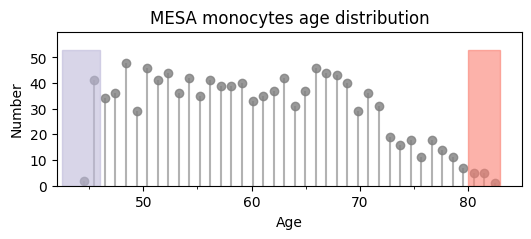

In [10]:
fig, ax = plt.subplots(figsize=(6, 2))

h, x = np.histogram(dnam_df['age'], bins=40)
x_=(x[:-1]+x[1:])/2
mask = (h == 0)

ax.vlines(x_[~mask], ymin=0, ymax=h[~mask], color='grey', alpha=0.6, zorder=0)
ax.scatter(x_[~mask], h[~mask], color='grey', alpha=0.8)


ax.add_patch(Rectangle(xy=(42.5, 0), width=3.5, height=max(h)+5, color=colors[0], alpha=0.6))
ax.add_patch(Rectangle(xy=(80, 0), width=3, height=max(h)+5, color=colors[1], alpha=0.6))

ax.set_xticks(np.arange(50, 86, 10))
ax.set_xticks(np.arange(45, 85, 5), minor=True)
ax.set_yticks(np.arange(0, 51, 10))
ax.set_xlim(42, 85)
ax.set_ylim(0, 60)
ax.set_xlabel('Age')
ax.set_ylabel('Number')
ax.set_title('MESA monocytes age distribution')

plt.show()

**Select oldest and youngest**

In [11]:
young_dnam_df = dnam_df.query('age < 46')
old_dnam_df = dnam_df.query('age > 80')

In [12]:
# calculate average DNAm fractions
young_dnam_avg = young_dnam_df.mean()[:-1]
old_dnam_avg = old_dnam_df.mean()[:-1]

# save the average DNAm fraction of youngest as the starting DNAm fraction 
starnting_dnam_frac = young_dnam_avg.copy()

# calculate an effect size as a difference between young and old
effect_sizes = old_dnam_avg - young_dnam_avg

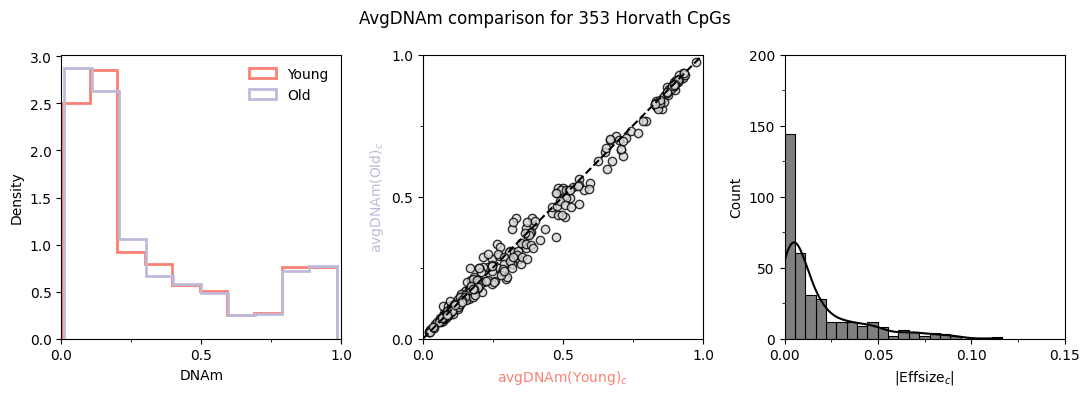

In [136]:
fig, ax = plt.subplots(1, 3, figsize=(11, 4))


ax[0].hist(young_dnam_df.to_numpy()[:, :-1].flatten(), histtype="step", density=True,
           linewidth=2, edgecolor=colors[1], label='Young')
ax[0].hist(old_dnam_df.to_numpy()[:, :-1].flatten(), histtype="step", density=True, 
           linewidth=2, edgecolor=colors[0], label='Old')
ax[0].set_xlabel('DNAm')
ax[0].set_ylabel('Density')
ax[0].set_xticks(np.arange(0, 1.01, 0.5))
ax[0].set_xticks(np.arange(0, 1.01, 0.25), minor=True)
# ax[0].set_yticks(np.arange(0, 1.01, 0.5))
# ax[0].set_yticks(np.arange(0, 1.01, 0.25), minor=True)
ax[0].set_xlim(0, 1)
ax[0].legend(frameon=False)


ax[1].scatter(young_dnam_avg, old_dnam_avg, color=colors[-1], edgecolors=colors[-2], alpha=0.8)
ax[1].plot([0, 1], [0, 1], ls="--", color=colors[-2])
ax[1].set_xlabel('avgDNAm(Young)$_c$', color=colors[1])
ax[1].set_ylabel('avgDNAm(Old)$_c$', color=colors[0])
ax[1].set_xticks(np.arange(0, 1.01, 0.5))
ax[1].set_xticks(np.arange(0, 1.01, 0.25), minor=True)
ax[1].set_yticks(np.arange(0, 1.01, 0.5))
ax[1].set_yticks(np.arange(0, 1.01, 0.25), minor=True)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)


sns.histplot(effect_sizes.abs(), ax=ax[2], color=colors[-2], 
             alpha=0.5, kde=True)
ax[2].set_xlabel('|Effsize$_c$|')
ax[2].set_xticks(np.arange(0, 0.21, 0.05))
ax[2].set_xticks(np.arange(0, 0.21, 0.025), minor=True)
ax[2].set_yticks(np.arange(0, 201, 50))
ax[2].set_yticks(np.arange(0, 201, 25), minor=True)
ax[2].set_xlim(0, 0.15)
ax[2].set_ylim(0, 200)

plt.suptitle('AvgDNAm comparison for 353 Horvath CpGs')
plt.tight_layout()
plt.show()

## Optimize parameters of StocH

In the procedure described above, there are two parameters need to be optimized: global methylation change rate $\gamma$, and $\sigma$, defining the methylation magnitude of of methylation change.
This section is dedicated to optimization of the parameters such that the obtained stochastic clocks would have the DNAm at the end of simulation (e.g. for Old samples) similar to ovserved DNAm (for observed Old samples).

In [ ]:
"""
here and after the np.vectorize functions are used
the way of this code operation is given in this cell
"""


@np.vectorize
def test_mul(x, y):
    return x * y


a = np.array([0, 1, 2, 3])
b = np.array([4, 5])

test_mul(a, b[:, np.newaxis])

"""
resulting matrix consists of the following elements:
a[0] * b[0]     a[1] * b[0]    a[2] * b[0], ...
a[1] * b[1]     a[1] * b[1]    a[2] * b[0], ...
"""

array([[ 0,  4,  8, 12],
       [ 0,  5, 10, 15]])

Definition of emission of the state change:

In [104]:
@np.vectorize
def p_c(effsize, gamma):
    """
    calculate the probability of methylation state for particular effect size of CpG (effsize_c) and 
    global probability of a DNAm change (gamma)
    """
    return 1 - np.exp(-gamma * np.abs(effsize))


@np.vectorize
def change_state_status(effsize_c, gamma):
    """
    emits the state of methylation, based on defined effect size of CpG (effsize_c) and 
    global probability of a DNAm change (gamma)
    """
    p = p_c(effsize_c, gamma)
    return np.random.choice([0, 1], 1, True, [1-p, p])[0]


# an example
gamma = np.array([1, 2, 3, 6])
effsize_c = np.array([0.05, 0.08, -0.06])

# change_state_status(effsize_c, gamma[:, np.newaxis])

Define the logic of the DNAm change:

In [159]:
# @np.vectorize
def r_c(sigma):
    return truncnorm.rvs(a=0, b=np.inf, loc=0, scale=sigma)


# @np.vectorize
def x_c(beta_c):
    return norm.ppf(beta_c)


# @np.vectorize
def x_c_next(x_c_, sigma, effsize_c):
    return x_c_ + np.sign(effsize_c) * r_c(sigma)

@np.vectorize
def beta_c_next(effsize_c, gamma, beta_c, sigma):
    ch_st = change_state_status(effsize_c, gamma)
    if ch_st == 1:
        x_c_val = x_c(beta_c)
        x_c_next_val = x_c_next(x_c_val, sigma, effsize_c)
        return norm.cdf(x_c_next_val)
    else:
        return beta_c


Try to apply the procedure to fixed $\gamma$ and $\sigma$ for see the dynamics of change of DNAm.

In [172]:
n_steps = 37 * 35
dnams = []
# first step depends on avgDNAm(young)
dnams.append(beta_c_next(effsize_c=effect_sizes, gamma=9.25, beta_c=young_dnam_avg, sigma=0.0005))

# next steps depend on previous states
for t in range(n_steps - 1):
    if t % 100 == 0:
        print(f'Time step {t}')
    dnams.append(beta_c_next(effsize_c=effect_sizes, gamma=9.25, beta_c=dnams[-1], sigma=0.0005))

Time step 0
Time step 100
Time step 200
Time step 300
Time step 400
Time step 500
Time step 600
Time step 700
Time step 800
Time step 900
Time step 1000
Time step 1100
Time step 1200


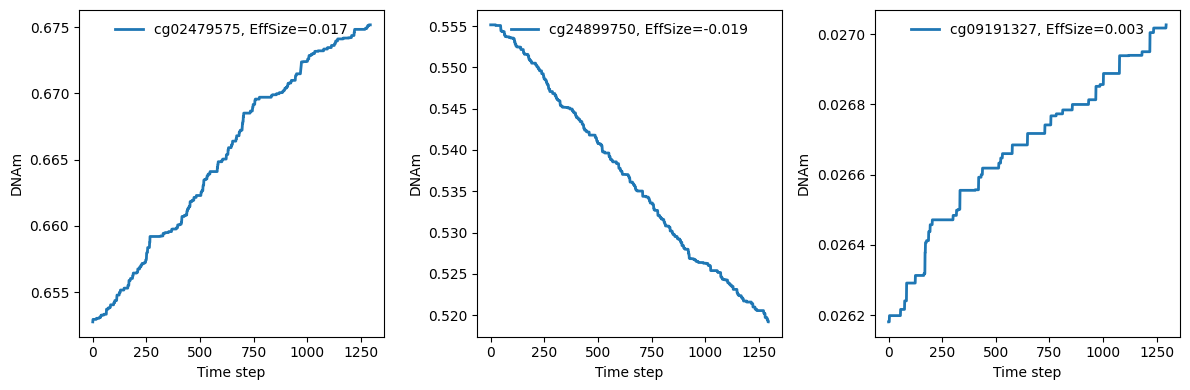

In [206]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

for i in range(3):
    r = np.random.randint(0, 353)
    ax[i].plot(range(n_steps), np.array(dnams)[:, r], linewidth=2,
               label=f'{cpg_ids.loc[r]}, EffSize={round(effect_sizes.iloc[r], 3)}')
    ax[i].set_xlabel('Time step')
    ax[i].set_ylabel('DNAm')
    ax[i].legend(loc='upper center', frameon=False)

plt.tight_layout()

In [207]:
last_dnam_step = dnams[-1]
mean_absolute_error(old_dnam_avg, last_dnam_step)

0.005101215860822679

# Questions

1. Can resulted modelled DNAm exceed 1? There is no restricting conditions.

# Suggestions

1. Can we consider non-homogeneous Markov process by define time-dependent global methylation rate $\gamma$?

